In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import random

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize, CenterCrop
from tqdm.notebook import tqdm

from pytz import timezone
import datetime as dt

import timm

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

from f1score import f1_loss

# import wandb
# wandb.init(project="stratified_imgcls", entity='dayday')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
SEED = 25
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)  # type: ignore
torch.backends.cudnn.deterministic = True  # type: ignore
torch.backends.cudnn.benchmark = True  # type: ignore

In [9]:
### Configurations
data_dir = '/opt/ml/input/data/train'
img_dir = f'{data_dir}/images'
df_path = f'{data_dir}/train.csv'
load_path = "/opt/ml/code/saved/epoch15_batch20_scheduler_resnet101e_pretrained2.pt"
mean, std = (0.5, 0.5, 0.5), (0.2, 0.2, 0.2)
log = []
c = ''
time = (dt.datetime.now().astimezone(timezone("Asia/Seoul")).strftime("%Y-%m-%d_%H:%M:%S"))

In [4]:
from albumentations import *
from albumentations.pytorch import ToTensorV2


def get_transforms(need=('train', 'val'), img_size=(512, 384), mean=(0.548, 0.504, 0.479), std=(0.237, 0.247, 0.246)):
    """
    train 혹은 validation의 augmentation 함수를 정의합니다. train은 데이터에 많은 변형을 주어야하지만, validation에는 최소한의 전처리만 주어져야합니다.
    
    Args:
        need: 'train', 혹은 'val' 혹은 둘 다에 대한 augmentation 함수를 얻을 건지에 대한 옵션입니다.
        img_size: Augmentation 이후 얻을 이미지 사이즈입니다.
        mean: 이미지를 Normalize할 때 사용될 RGB 평균값입니다.
        std: 이미지를 Normalize할 때 사용될 RGB 표준편차입니다.

    Returns:
        transformations: Augmentation 함수들이 저장된 dictionary 입니다. transformations['train']은 train 데이터에 대한 augmentation 함수가 있습니다.
    """
    transformations = {}
    if 'train' in need:
        transformations['train'] = Compose([
            CenterCrop(img_size[1],img_size[1]),
            Resize(224,224),
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            GaussNoise(p=0.5),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    if 'val' in need:
        transformations['val'] = Compose([
            CenterCrop(img_size[1],img_size[1]),
            Resize(224,224),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    return transformations

In [5]:
### 마스크 여부, 성별, 나이를 mapping할 클래스를 생성합니다.

class MaskLabels:
    mask = 0
    incorrect = 1
    normal = 2

class GenderLabels:
    male = 0
    female = 1

class AgeGroup:
    map_label = lambda x: 0 if int(x) < 30 else 1 if int(x) < 60 else 2



class MaskBaseDataset(data.Dataset):
    num_classes = 3 * 2 * 3

    _file_names = {
        "mask1.jpg": MaskLabels.mask,
        "mask2.jpg": MaskLabels.mask,
        "mask3.jpg": MaskLabels.mask,
        "mask4.jpg": MaskLabels.mask,
        "mask5.jpg": MaskLabels.mask,
        "incorrect_mask.jpg": MaskLabels.incorrect,
        "normal.jpg": MaskLabels.normal
    }

    image_paths = []
    mask_labels = []
    gender_labels = []
    age_labels = []

    def __init__(self, img_dir, transform=None):
        """
        MaskBaseDataset을 initialize 합니다.

        Args:
            img_dir: 학습 이미지 폴더의 root directory 입니다.
            transform: Augmentation을 하는 함수입니다.
        """
        self.img_dir = img_dir
        self.mean = mean
        self.std = std
        self.transform = transform

        self.setup()

    def set_transform(self, transform):
        """
        transform 함수를 설정하는 함수입니다.
        """
        self.transform = transform
        
    def setup(self):
        """
        image의 경로와 각 이미지들의 label을 계산하여 저장해두는 함수입니다.
        """
        profiles = os.listdir(self.img_dir)
        for profile in profiles:
            for file_name, label in self._file_names.items():
                img_path = os.path.join(self.img_dir, profile, file_name)  # (resized_data, 000004_male_Asian_54, mask1.jpg)
                if os.path.exists(img_path):
                    self.image_paths.append(img_path)
                    self.mask_labels.append(label)

                    id, gender, race, age = profile.split("_")
                    gender_label = getattr(GenderLabels, gender)
                    age_label = AgeGroup.map_label(age)

                    self.gender_labels.append(gender_label)
                    self.age_labels.append(age_label)

    def __getitem__(self, index):
        """
        데이터를 불러오는 함수입니다. 
        데이터셋 class에 데이터 정보가 저장되어 있고, index를 통해 해당 위치에 있는 데이터 정보를 불러옵니다.
        
        Args:
            index: 불러올 데이터의 인덱스값입니다.
        """
        # 이미지를 불러옵니다.
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        
        # 레이블을 불러옵니다.
        mask_label = self.mask_labels[index]
        gender_label = self.gender_labels[index]
        age_label = self.age_labels[index]
        multi_class_label = mask_label * 6 + gender_label * 3 + age_label
        
        # 이미지를 Augmentation 시킵니다.
        image_transform = self.transform(image=np.array(image))['image']
        return image_transform, multi_class_label

    def encode_class(self,m,g,a):        
        return m*6+g*3+a

    def __len__(self):
        return len(self.image_paths)


class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform
        
    def set_transform(self, transform):
        """
        transform 함수를 설정하는 함수입니다.
        """
        self.transform = transform
        
    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image=np.array(image))['image']
        return image

    def __len__(self):
        return len(self.img_paths)

In [6]:
# 정의한 Augmentation 함수와 Dataset 클래스 객체를 생성합니다.
transform = get_transforms(mean=mean, std=std)

dataset = MaskBaseDataset(
    img_dir=img_dir,
)
dataset.set_transform(transform['val'])



num_epochs = 1
batch_size = 32
learning_rate = 1e-3
patience = 10
accumulation_steps = 2
best_val_loss = np.inf

test_dir = '/opt/ml/input/data/eval'
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

test_dataset = TestDataset(image_paths, transform)
test_dataset.set_transform(transform['val'])
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)


In [10]:
# log.append(f'Model         : {res_model.__class__.__name__}')
log.append(f'  load_state  : {load_path}')
log.append(f'Dataset       : {dataset.__class__.__name__}')
# log.append(f'Train_trans   : {TrainTrans.__name__}')
# log.append(f'Test_trans    : {TestTrans.__name__}')
log.append(f'Start_time    : {time}')
log.append(f'Device        : {device}')
# log.append(f'CLASS_NUM     : {CLASS_NUM}')
# log.append(f'NUM_WORKERS   : {NUM_WORKERS}')
log.append(f'BATCH_SIZE    : {batch_size}')
log.append(f'NUM_EPOCH     : {num_epochs}')
# log.append(f'SAVE_INTERVAL : {SAVE_INTERVAL}')


for line in log:
    print(line)

  load_state  : /opt/ml/code/saved/epoch15_batch20_scheduler_resnet101e_pretrained2.pt
Dataset       : MaskBaseDataset
Start_time    : 2021-08-27_10:28:13
Device        : cuda
BATCH_SIZE    : 32
NUM_EPOCH     : 1


In [11]:
# wandb init
config={"epochs": num_epochs, "batch_size": batch_size, "learning_rate" : learning_rate}

n_fold = 5
skf = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=SEED)

all_preds = [0 for _ in range(len(test_dataset))]
labels = [dataset.encode_class(m,g,a) for m,g,a in zip(dataset.mask_labels, dataset.gender_labels, dataset.age_labels)]
for fold, (train_ids, val_ids) in enumerate(skf.split(dataset.image_paths, labels)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    log.append(f'{c:#^80}')
    log.append(f'FOLD {fold}')
    log.append(c)

    counter = 0
    best_val_acc = 0
    
    # fold별 dataset 정의
    train_dataset = Subset(dataset, train_ids)
    val_dataset = Subset(dataset, val_ids)

    log.append(f'  train_len    {len(train_dataset)}')
    log.append(f'  test_len     {len(val_dataset)}')
    log.append(c)
    # train_dataset.dataset.set_transform(transform['train'])
    # val_dataset.dataset.set_transform(transform['val'])

    res_model = timm.create_model(model_name = "resnest101e", num_classes = 18, pretrained = True)
    res_model.load_state_dict(torch.load(load_path))
    res_model.to(device)

    # Loss, optim
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(res_model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, 'max',factor = 0.5, patience=2)

    train_loader = data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        num_workers=2,
        shuffle=True
    )

    val_loader = data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        num_workers=2,
        shuffle=False
    )

    # wandb.init(project="stratified_imgcls", config=config)
    # wandb.run.name = f'{fold}fold_{num_epochs}epoch_{batch_size}batch_resnest101e'
 
    for epoch in range(5):# num_epochs):
        print('*** Epoch {} ***'.format(epoch))

        log.append(c)
        log.append('*** Epoch {} ***'.format(epoch))
        log.append(c)
        # Training
        res_model.train()  
        running_loss, running_acc, running_f1 = 0.0, 0.0, 0.0
            
        for idx, (inputs, labels) in enumerate(tqdm(train_loader)):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # forward
            with torch.set_grad_enabled(True):
                logits = res_model(inputs)
                _, preds = torch.max(logits, 1)
                loss = criterion(logits, labels)

                loss.backward()
                optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.shape[0]
                running_acc += torch.sum(preds == labels.data)
                running_f1 += f1_score(labels.data.cpu().numpy(), preds.cpu().numpy(), average = 'macro')
                # f1_loss(labels.data, preds)

        epoch_acc = running_acc/len(train_loader.dataset)
        epoch_loss = running_loss/len(train_loader.dataset)
        epoch_f1 = running_f1/len(train_loader)
        print('{} Loss: {:.4f} Acc: {:.4f} F1-score: {:.4f}'.format('train', epoch_loss, epoch_acc, epoch_f1))
        log.append(f"Train : [FOLD {fold}] Epoch {epoch:0>3d} // (avg) Loss : {epoch_loss:.3f}, Accuracy : {epoch_acc:.3f}, F1 : {epoch_f1:.3f}")
           
        # Validation
        res_model.eval()
        valid_acc, valid_f1,valid_loss = 0.0, 0.0, 0.0
            
        for idx, (inputs, labels) in enumerate(tqdm(val_loader)):
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.set_grad_enabled(False):
                logits = res_model(inputs)
                _, preds = torch.max(logits, 1)

                # statistics
                valid_acc += torch.sum(preds == labels.data)
                valid_f1 += f1_score(labels.data.cpu().numpy(), preds.cpu().numpy(), average = 'macro')
                valid_loss += criterion(logits, labels).item()

        # val_acc /= (idx+1) * batch_size
        # val_f1 /= (idx+1) * batch_size
        # val_loss /= (idx+1) * batch_size

        valid_acc /= len(val_loader.dataset)
        valid_f1 /= len(val_loader)
        valid_loss /= len(val_loader.dataset)

        scheduler.step(valid_acc)

        if valid_loss < best_val_loss:
                best_val_loss = valid_loss
        if valid_acc > best_val_acc:
            print("New best model for val accuracy!")
            print(f"val_acc : {valid_acc}")
            torch.save(res_model.state_dict(), f"saved/{fold}fold_{epoch:02}_accuracy_{valid_acc:4.2%}.ckpt")
            best_val_acc = valid_acc
            counter = 0
            log.append("New best model for val accuracy! val_acc : {valid_acc}")
        else:
            counter += 1
        # Callback2: patience 횟수 동안 성능 향상이 없을 경우 학습을 종료시킵니다.
        if counter > patience:
            print("Early Stopping...")
            log.append('Early Stopping')
            log.append(c)
            break


        print('{} Acc: {:.4f} f1-score: {:.4f}\n'.format('valid', valid_acc, valid_f1))
        log.append(f"Valid : [FOLD {fold}] Epoch {epoch:0>3d} // (avg) Loss : {valid_loss:.3f}, Accuracy : {valid_acc:.3f}, F1 : {valid_f1:.3f}")
        log.append(c)
        # wandb.log({'train_acc': epoch_acc ,'val_acc': val_acc})# 'train_f1': epoch_f1, 'val_f1':val_f1})


    # pred    
    all_predictions = []
    for images in tqdm(test_loader):
        with torch.no_grad():
            images = images.to(device)
            outputs = res_model(images)
            all_predictions.extend(outputs.cpu().numpy())

    all_preds = [x+y for x,y in zip(all_preds,all_predictions)]

submission['ans'] = np.argmax(all_preds,axis = 1)
submission.to_csv(os.path.join(test_dir, 'submission_30epoch_4batch_stratified_split5.csv'), index=False)
print('test inference is done!')
log.append(c)
log.append("submission file saved")
log.append(c)
# log 저장
with open(os.path.join('/opt/ml/code/saved', f'{time}.log'), "w") as f:
    now = (dt.datetime.now().astimezone(timezone("Asia/Seoul")).strftime("%Y%m%d_%H%M%S"))
    log.append(f'Finish_Date    : {now}')
    print(log[-1])
    for line in log: 
        f.write(line+'\n')

FOLD 0
--------------------------------
*** Epoch 0 ***


In [15]:
submission.to_csv(os.path.join(test_dir, 'submission_30epoch_4batch_stratified_split5.csv'), index=False)
print('test inference is done!')

test inference is done!


In [49]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

labels = [dataset.encode_class(m,g,a) for m,g,a in zip(dataset.mask_labels, dataset.gender_labels, dataset.age_labels)]

print(pd.DataFrame(labels).value_counts().sort_index())#*100/len(labels))

all_preds = [0 for _ in range(len(test_dataset))]
labels = [dataset.encode_class(m,g,a) for m,g,a in zip(dataset.mask_labels, dataset.gender_labels, dataset.age_labels)]
for fold, (train_ids, val_ids) in enumerate(skf.split(dataset.image_paths, labels)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    break
    # fold별 dataset 정의
    train_dataset = Subset(dataset, train_ids)
    val_dataset = Subset(dataset, val_ids)

    trainlabels = [dataset.encode_class(m,g,a) for idx, (m,g,a) in enumerate(zip(dataset.mask_labels, dataset.gender_labels, dataset.age_labels)) if idx in train_ids]
    valabels = [dataset.encode_class(m,g,a) for idx, (m,g,a) in enumerate(zip(dataset.mask_labels, dataset.gender_labels, dataset.age_labels)) if idx in val_ids]
    print('train dataset length : ',len(train_dataset))
    print('valid dataset length : ',len(val_dataset))

    print(pd.DataFrame(trainlabels).value_counts().sort_index())#*100/len(labels))
    print(pd.DataFrame(valabels).value_counts().sort_index())#*100/len(labels))


0     2339
1     2050
2      415
3     3449
4     4085
5      545
6      468
7      410
8       83
9      689
10     817
11     109
12     468
13     410
14      83
15     689
16     817
17     109
dtype: int64
FOLD 0
--------------------------------


In [61]:
train_dataset.dataset.set_transform(transform['train'])
val_dataset.dataset.set_transform(transform['val'])

In [62]:
train_loader = data.DataLoader(
    train_dataset,
    batch_size=12,
    shuffle=True
)

In [63]:
images, labels = next(iter(train_loader))

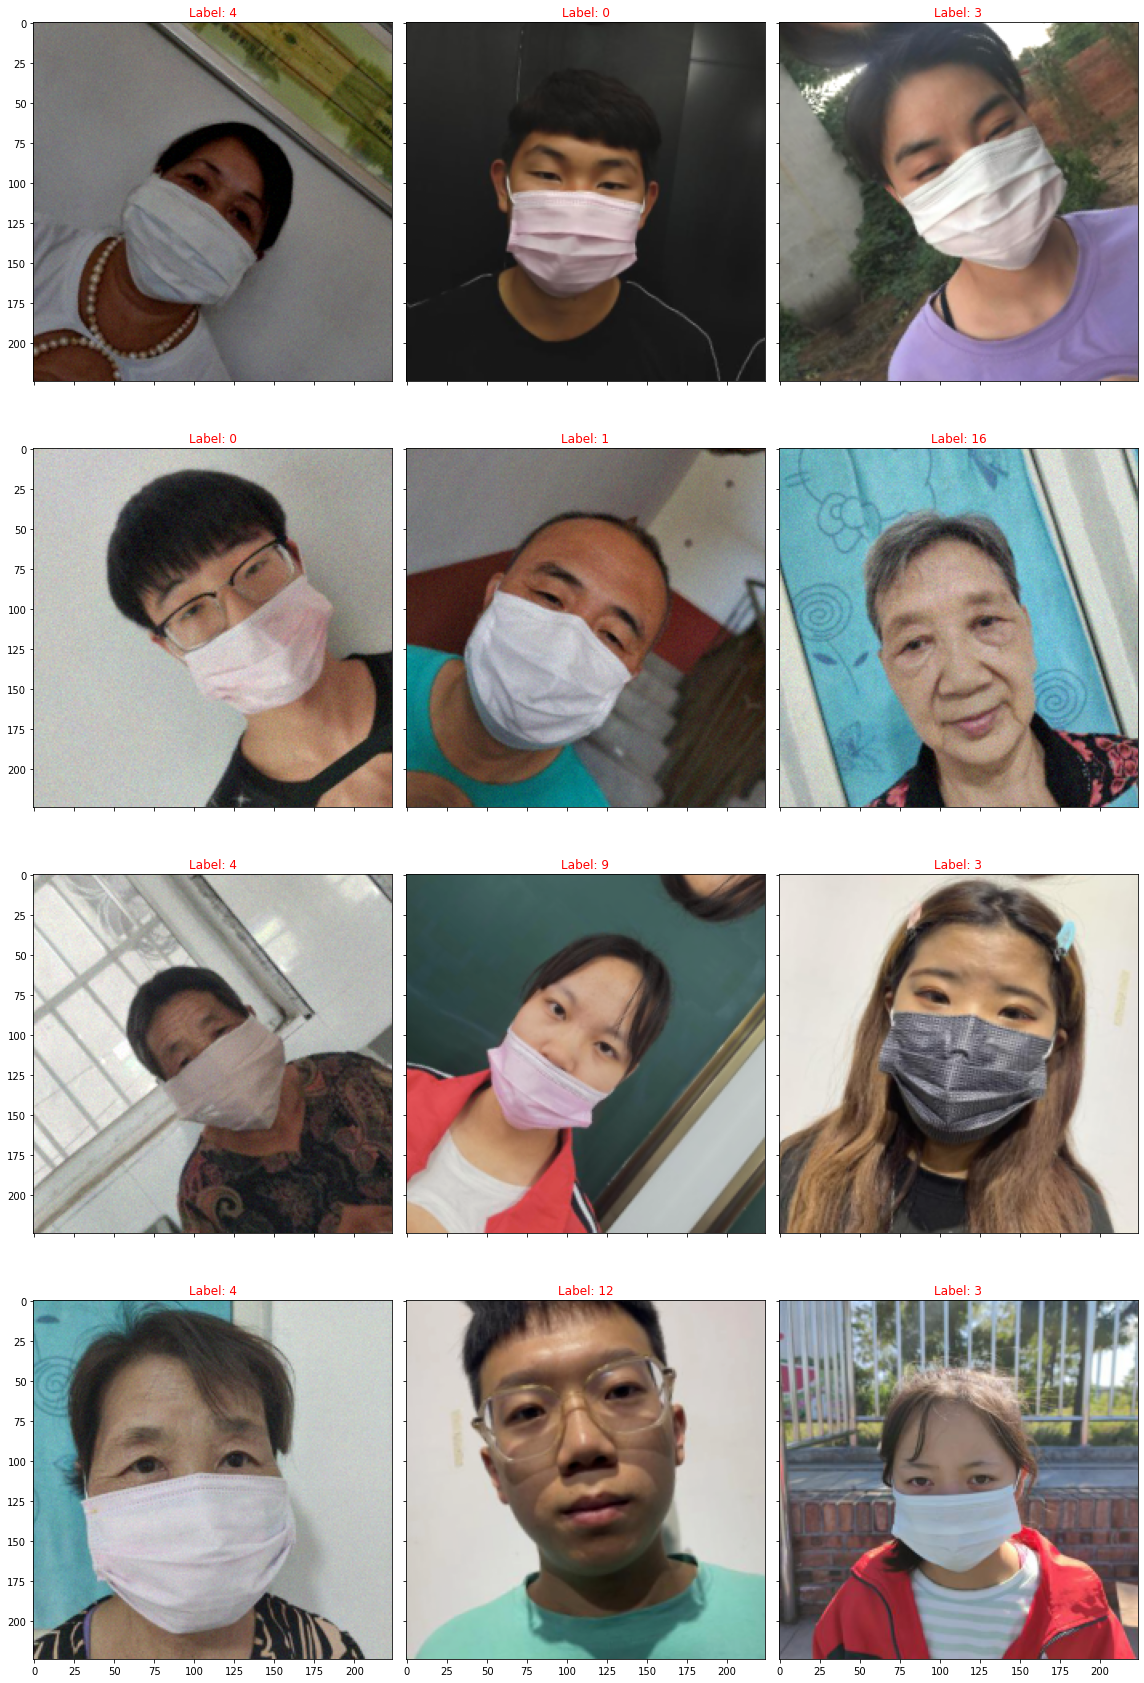

In [64]:
from torchvision import transforms

# Augmentation으로 이미지를 Normalize했기 때문에, 역으로 다시 Normalize 해주어야합니다.
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1 / s for s in std]
)

n_rows, n_cols = 4, 3

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(16, 24))
for i in range(n_rows*n_cols):
    axes[i%n_rows][i//(n_cols+1)].imshow(inv_normalize(images[i]).permute(1, 2, 0))
    axes[i%n_rows][i//(n_cols+1)].set_title(f'Label: {labels[i]}', color='r')
plt.tight_layout()

## data loader에서 dataset.set_transform하기

In [66]:
train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
test_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

In [74]:
trainloader1= data.DataLoader(
    dataset.set_transform(transform['train']),
    batch_size=10,
    sampler=train_subsampler)
testloader = data.DataLoader(dataset.set_transform(transform['val']),batch_size=10, sampler=test_subsampler)

In [75]:
images, labels = next(iter(trainloader1))

TypeError: 'NoneType' object is not subscriptable